In [9]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
# from flaml import AutoML
# from sklearn.ensemble import HistGradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
# from sklearn.linear_model import ElasticNet
# from sklearn.tree import DecisionTreeRegressor

# from lightgbm import LGBMRegressor
from prettytable import PrettyTable
import sys  
import os
root_path = os.path.realpath('/..')
sys.path.insert(0, root_path)
%load_ext autoreload
%autoreload 2

from variance_reduction.diff_in_means import DifferenceInMeans
from variance_reduction.cuped import CUPED, multiple_CUPEDs, MultivariateCUPED
from variance_reduction.utils import create_pretty_table, query_snowflake, bootstrap_generator, subsample_generator, bootstrap_data, subsample_data, aaify, add_synthetic_effect
# from variance_reduction.mlrate import MLRATE, AltMLRATE
# from variance_reduction.cupac import CUPAC
# from variance_reduction.doubly_robust import DoublyRobustEstimator
from variance_reduction.evaluation_pipeline import VREvaluation, VREvaluationAll
from variance_reduction.multivariate_regression import MultivariateRegression, MultivariateRegressionAdjusted


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple synthetic data

In [10]:
def generate_synthetic_data(n):

    # pre experiment metric
    group_0 = np.random.exponential(10, n//2)
    group_1 = np.random.exponential(10, n//2)

    pre_metric = np.concatenate([group_0, group_1])

    # experiment metric
    ctrl_group_0 = group_0 + np.random.normal(0,1, n//2)
    treatment_group_1 = group_1 + np.random.normal(5,1, n//2) + np.random.normal(0,1, n//2)

    exp_metric = np.concatenate([ctrl_group_0, treatment_group_1])

    # treatment
    treatment = np.concatenate([np.zeros(n//2), np.ones(n//2)])

    # assemble dataframe
    df = pd.DataFrame({
        'Y': exp_metric,
        'T': treatment,
        'X': pre_metric
    })

    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [11]:
simple_synthetic_df = generate_synthetic_data(10000)

## MultivariateCUPED

In [15]:
MultiCUPED_params_map = {
    'MultivariateCUPED' : {
        'covariate_columns': ['X']
    }
}

In [18]:
multi_cuped_evaluation = VREvaluation(MultivariateCUPED)
multi_cuped_evaluation = multi_cuped_evaluation.run(data=simple_synthetic_df,
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_map=MultiCUPED_params_map,
                                      verbose=True,
                                      n_bootstrap=100)

Running MultivariateCUPED...


100%|██████████| 100/100 [00:01<00:00, 73.91it/s]


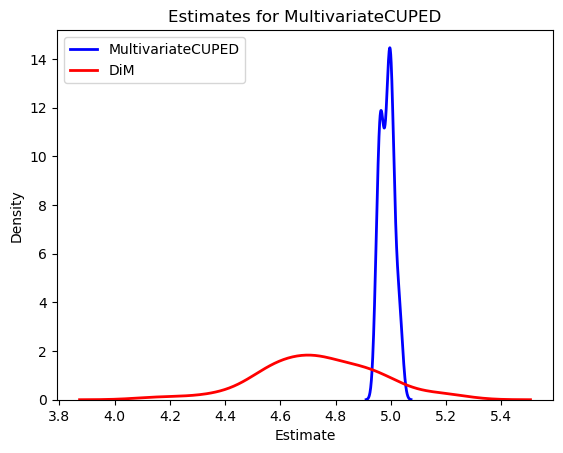

In [19]:
multi_cuped_evaluation.plot(plot_what='estimates')

## CUPED vs MultivariateCUPED

In [21]:
cupeds_params_map = {
    'MultivariateCUPED' : {
            'covariate_columns': ['X']
        },
    'CUPED' : {
        'covariate_column': 'X'
    }
}

In [24]:
cupeds_evaluation = VREvaluationAll([CUPED, MultivariateCUPED])
cupeds_evaluation = cupeds_evaluation.run_all(data=simple_synthetic_df,
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_map=cupeds_params_map,
                                      verbose=True,
                                      n_bootstrap=100)

Running CUPED...


100%|██████████| 100/100 [00:01<00:00, 69.09it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:01<00:00, 76.67it/s]

Done!


In [26]:
cupeds_evaluation.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,CUPED,4.983257,"(4.938419563182486, 5.038652469432129)",None,None,0.0,"(0.0, 0.0)",None,0.983575
1,MultivariateCUPED,4.983257,"(4.938419563182489, 5.038652469432129)",None,None,0.0,"(0.0, 0.0)",None,0.983575


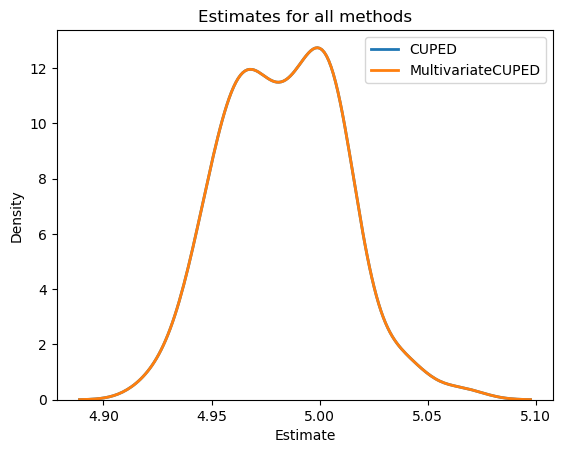

In [25]:
cupeds_evaluation.plot(plot_what='estimates')

# Synthetic data MLRATE paper and other VR methods

In [74]:
def dgp(n=2000, p=10, linear=True, constant=True):
    """DGP from https://github.com/muratunalphd/Blog-Posts/blob/main/variance-reduction-methods/MLRATE.ipynb"""
        
    Xmat = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float32')

    T = np.random.binomial(1, 0.5, n).astype('int8')

    col_list = ['X' + str(x) for x in range(1,(p+1))]

    df = pd.DataFrame(Xmat, columns = col_list)
    
    # functional form of the covariates
    if linear:
        B = 225 + 50*df['X1'] + 5*df['X2'] + 20*(df['X3']-0.5) + 10*df['X4'] + 5*df['X5']
    else:
        B = 225 + 50*df['X1'] + 5*np.sin(np.pi*df['X1']*df['X2'] ) + 10*(df['X3']-0.5)**2 + 10*df['X4']**2 + 5*df['X5']**3
    
    # constant ate or non-constant
    tau = 1.8 if constant else 5*df['X1'] + 5*np.log(1 + np.exp(df['X2']))
    
    # Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
    Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
        
    df['T'] = T
    df['Y'] = Y    
    return df

In [75]:
nonlinear_synthetic_df = dgp(n=2000, p=10, linear=False, constant=True)
linear_synthetic_df = dgp(n=2000, p=10, linear=True, constant=True)

## CUPED vs MultivariateCUPED

### Linear

In [76]:
linear_synthetic_df.cov()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,T,Y
X1,0.983304,0.014045,-0.000189,0.008015,-0.016065,-0.001043,0.004428,0.020371,-0.022790,-0.020885,-0.004188,49.597994
X2,0.014045,1.006121,0.031699,-0.015039,-0.008409,-0.016452,-0.001691,-0.007508,0.031357,-0.000964,-0.020979,6.126487
X3,-0.000189,0.031699,1.005702,0.005195,-0.014588,-0.004972,-0.020226,0.028291,0.028903,-0.007292,0.020594,19.880386
X4,0.008015,-0.015039,0.005195,0.950916,-0.019210,0.021071,-0.018722,0.056751,0.010907,0.008695,0.016558,9.491887
X5,-0.016065,-0.008409,-0.014588,-0.019210,1.018603,0.002247,-0.013766,-0.028570,0.027674,0.057351,-0.008553,4.269846
X6,-0.001043,-0.016452,-0.004972,0.021071,0.002247,1.083981,-0.002390,-0.006789,-0.024002,0.009376,-0.013176,-0.892172
X7,0.004428,-0.001691,-0.020226,-0.018722,-0.013766,-0.002390,0.985049,0.019813,-0.017142,-0.018450,-0.004985,-1.282637
X8,0.020371,-0.007508,0.028291,0.056751,-0.028570,-0.006789,0.019813,1.000475,0.005235,0.020190,0.011552,3.074354
X9,-0.022790,0.031357,0.028903,0.010907,0.027674,-0.024002,-0.017142,0.005235,1.022528,-0.002701,0.004808,0.908595
X10,-0.020885,-0.000964,-0.007292,0.008695,0.057351,0.009376,-0.018450,0.020190,-0.002701,1.063877,0.013747,-1.224379


In [85]:
cupeds_params_map2 = {
    'DifferenceInMeans':{
    },
    'CUPED' : {
        'covariate_column': linear_synthetic_df.columns.to_list()[1]
    },
    'MultivariateCUPED' : {
            'covariate_columns': linear_synthetic_df.columns.to_list()[1:10]
    }
    
}

In [89]:
cupeds_evaluation2 = VREvaluationAll([DifferenceInMeans, CUPED, MultivariateCUPED])
cupeds_evaluation2 = cupeds_evaluation2.run_all(data=linear_synthetic_df,
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_map=cupeds_params_map2,
                                      verbose=True,
                                      n_bootstrap=100,
                                      true_ate=1.8)

Running DifferenceInMeans...


100%|██████████| 100/100 [00:00<00:00, 215.03it/s]


Running CUPED...


100%|██████████| 100/100 [00:01<00:00, 94.11it/s]


Running MultivariateCUPED...


100%|██████████| 100/100 [00:01<00:00, 97.57it/s]

Done!


In [90]:
cupeds_evaluation2.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,2.365392,"(-4.042319486597556, 9.31087329178238)",0.565392,"(-5.842319486597557, 7.5108732917823815)",0.393116,"(0.0005433034428435092, 0.9593866974400347)",0.87,0.000000
1,CUPED,2.898544,"(-3.6393469471885735, 9.95359604175406)",1.098544,"(-5.439346947188573, 8.15359604175406)",0.337978,"(0.00021988404674572917, 0.9856818779158311)",0.84,-0.011226
2,MultivariateCUPED,0.686922,"(-4.5863098163990825, 7.104066568068748)",-1.113078,"(-6.386309816399082, 5.304066568068748)",0.442073,"(0.005554853525724459, 0.952841985068977)",0.85,0.074066


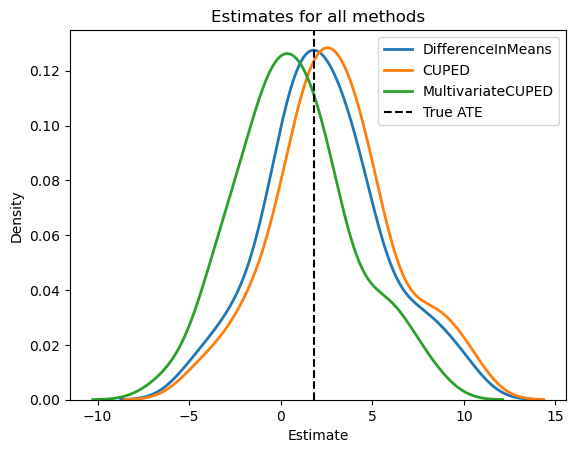

In [91]:
cupeds_evaluation2.plot(plot_what='estimates')

### Non linear

In [101]:
nonlinear_synthetic_df.cov()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,T,Y
X1,0.992923,0.009412,-0.021164,0.005297,-0.027109,0.013876,-0.026355,-0.018982,0.015787,-0.015703,-0.007047,49.731623
X2,0.009412,1.028178,0.030876,0.029096,0.002138,0.024983,0.017184,-0.013214,0.012836,0.002218,0.011061,-1.483488
X3,-0.021164,0.030876,1.013675,-0.009430,-0.022140,0.024327,-0.014378,-0.009432,-0.012086,0.008838,-0.019721,-11.882127
X4,0.005297,0.029096,-0.009430,0.941076,0.000586,-0.014963,0.005910,0.010061,0.027139,0.006989,-0.019052,1.509441
X5,-0.027109,0.002138,-0.022140,0.000586,1.043330,0.055562,0.010431,0.004748,0.030158,-0.009879,-0.001355,15.518870
X6,0.013876,0.024983,0.024327,-0.014963,0.055562,1.000555,-0.017017,-0.043804,-0.011584,-0.018859,0.004421,-0.491255
X7,-0.026355,0.017184,-0.014378,0.005910,0.010431,-0.017017,0.993894,0.003645,0.005553,0.008805,0.008454,-1.866427
X8,-0.018982,-0.013214,-0.009432,0.010061,0.004748,-0.043804,0.003645,0.992336,0.001295,0.011029,0.002199,-1.305605
X9,0.015787,0.012836,-0.012086,0.027139,0.030158,-0.011584,0.005553,0.001295,1.011970,-0.002815,-0.014707,1.526508
X10,-0.015703,0.002218,0.008838,0.006989,-0.009879,-0.018859,0.008805,0.011029,-0.002815,1.027168,-0.001970,-1.348664


In [108]:
cupeds_params_map3 = {
    'DifferenceInMeans':{
    },
    'CUPED' : {
        'covariate_column': nonlinear_synthetic_df.columns.to_list()[0]
    },
    'MultivariateCUPED' : {
            'covariate_columns': nonlinear_synthetic_df.columns.to_list()[0:5]
    }
    
}

In [112]:
cupeds_evaluation3 = VREvaluationAll([DifferenceInMeans, CUPED, MultivariateCUPED])
cupeds_evaluation3 = cupeds_evaluation3.run_all(data=nonlinear_synthetic_df,
                                      treatment_column='T',
                                      target_column='Y',
                                      method_params_map=cupeds_params_map3,
                                      verbose=True,
                                      n_bootstrap=1000,
                                      true_ate=1.8)

Running DifferenceInMeans...


100%|██████████| 1000/1000 [00:04<00:00, 243.24it/s]


Running CUPED...


100%|██████████| 1000/1000 [00:08<00:00, 113.66it/s]


Running MultivariateCUPED...


100%|██████████| 1000/1000 [00:09<00:00, 107.62it/s]

Done!


In [113]:
cupeds_evaluation3.report()

,Method,Estimate,Estimate CI,Bias,Bias CI,p-value,p-value CI,Coverage Probability,Variance Reduction
0,DifferenceInMeans,2.590834,"(-3.120385604167081, 7.741566572412593)",0.790834,"(-4.92038560416708, 5.941566572412593)",0.381220,"(0.006298824390205459, 0.9473668306022858)",0.953,0.000000
1,CUPED,4.006679,"(0.6308764244295546, 7.505649422477031)",2.206679,"(-1.1691235755704454, 5.705649422477031)",0.107512,"(3.2628943472672085e-05, 0.6193454724121827)",0.758,0.580955
2,MultivariateCUPED,3.465567,"(0.5136797706669317, 6.5587454862188945)",1.665567,"(-1.2863202293330682, 4.758745486218895)",0.106145,"(2.5815899999193853e-05, 0.6814134362735987)",0.825,0.684182


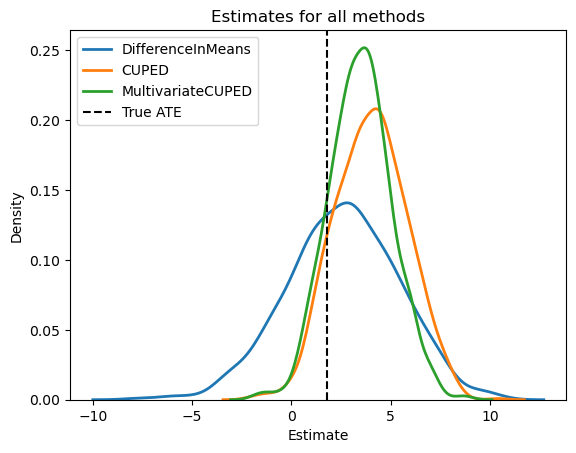

In [114]:
cupeds_evaluation3.plot(plot_what='estimates')